In [1]:
## General imports
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from tqdm import tqdm
from scipy.stats import norm
from scipy import stats

## Own functionality imports
"""
Kreeg dit niet aan de praat..
"""
# import sys
# sys.path.append('..')
# from scripts.functions import read_daily, remove_outlier

'\nKreeg dit niet aan de praat..\n'

In [2]:
def read_daily(city):
    """
    Takes in an abbreviation of a city and reads its json files to a dataframe.
    """
    folder_daily = locs[f"input_daily_{city}"]

    # import all files which end with .json from folder
    json_files = glob.glob(os.path.join(folder_daily, '*.json'))
    
    json_list = []
    for file in tqdm(json_files):
        with open(file, 'r') as f:
            data = json.load(f)
        json_list.append(data)
    
    # convert list of dfs to dataframe
    df_daily = pd.json_normalize(json_list)
    return df_daily

def remove_outlier(df):
    """
    Takes in data frame of 1 column (prod_daily) and removes the outliers.
    """
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    tresh_low  = q1-1.5*iqr
    tresh_high = q3+1.5*iqr
    df_out = df.loc[(df > tresh_low) & (df < tresh_high)]
    return df_out, tresh_low, tresh_high

## Define locations

In [3]:
locs = {'input_master_data' : os.path.join('..', 'data', 'input', 'data_productie', 'master_data.json'),
        'input_daily_BRU' : os.path.join('..', 'data', 'input', 'data_productie', 'daily_production', 'BRU'),
        'input_daily_STO' : os.path.join('..', 'data', 'input', 'data_productie', 'daily_production', 'STO')}
locs

{'input_master_data': '..\\data\\input\\data_productie\\master_data.json',
 'input_daily_BRU': '..\\data\\input\\data_productie\\daily_production\\BRU',
 'input_daily_STO': '..\\data\\input\\data_productie\\daily_production\\STO'}

## Read data

In [4]:
with open(locs['input_master_data'], 'r') as f:
    data_raw = json.load(f)
msr_data = pd.json_normalize(data_raw)
msr_data

,BRU msr,STO msr
0,1244,274


> **choose city 'BRU' or 'STO'**

In [5]:
city = 'STO'
df_daily_raw = read_daily(city)
df_daily_raw

100%|██████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:31<00:00, 58.44it/s]


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Monday,1,0,01-01-2018 00:00:00.0000,No,9,3,265
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,9,3,265
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,18,6,256
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,22,8,252
4,Friday,1,0,01-05-2018 00:00:00.0000,No,31,11,243
...,...,...,...,...,...,...,...,...
1825,Saturday,1,0,12-31-2022 00:00:00.0000,No,51,19,223
1826,Sunday,1,0,01-01-2023 00:00:00.0000,No,53,20,221
1827,Monday,1,0,01-02-2023 00:00:00.0000,No,61,22,213
1828,Tuesday,1,0,01-03-2023 00:00:00.0000,No,70,25,204


## Clean data

In [6]:
df_daily = df_daily_raw.copy()

# change type to numeric and change #MV (maintenance -> no production) to Nan
df_daily[['prod_loss', 'prod_loss_perc', 'production']] = (df_daily[['prod_loss', 'prod_loss_perc', 'production']]
                                                            .apply(pd.to_numeric, downcast='unsigned', errors='coerce'))
# increase readability of the date and delete useless columns
df_daily[['date', 'time_ignore']] = df_daily['date'].str.split(' ', expand = True)
df_daily = df_daily.drop(['time_ignore', 'minute', 'hour'], axis = 1)

## Explore

In [7]:
df_daily.sample(10)

,DoW,date,maintenance,prod_loss,prod_loss_perc,production
514,Thursday,05-30-2019,No,79.0,29.0,195.0
1318,Wednesday,08-11-2021,No,93.0,34.0,181.0
1581,Sunday,05-01-2022,No,73.0,27.0,201.0
1423,Wednesday,11-24-2021,No,71.0,26.0,203.0
1750,Monday,10-17-2022,No,56.0,20.0,218.0
1819,Sunday,12-25-2022,No,59.0,22.0,215.0
1422,Tuesday,11-23-2021,No,61.0,22.0,213.0
1079,Tuesday,12-15-2020,No,88.0,32.0,186.0
1797,Saturday,12-03-2022,No,83.0,30.0,191.0
569,Wednesday,07-24-2019,No,274.0,100.0,0.0


In [8]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoW             1830 non-null   object 
 1   date            1830 non-null   object 
 2   maintenance     1830 non-null   object 
 3   prod_loss       1716 non-null   float64
 4   prod_loss_perc  1716 non-null   float64
 5   production      1716 non-null   float64
dtypes: float64(3), object(3)
memory usage: 85.9+ KB


In [9]:
df_daily.describe()

,prod_loss,prod_loss_perc,production
count,1716.000000,1716.000000,1716.000000
mean,97.054196,35.429487,176.945804
std,63.080946,23.018391,63.080946
min,9.000000,3.000000,0.000000
25%,62.750000,23.000000,182.000000
50%,73.000000,27.000000,201.000000
75%,92.000000,33.250000,211.250000
max,274.000000,100.000000,265.000000


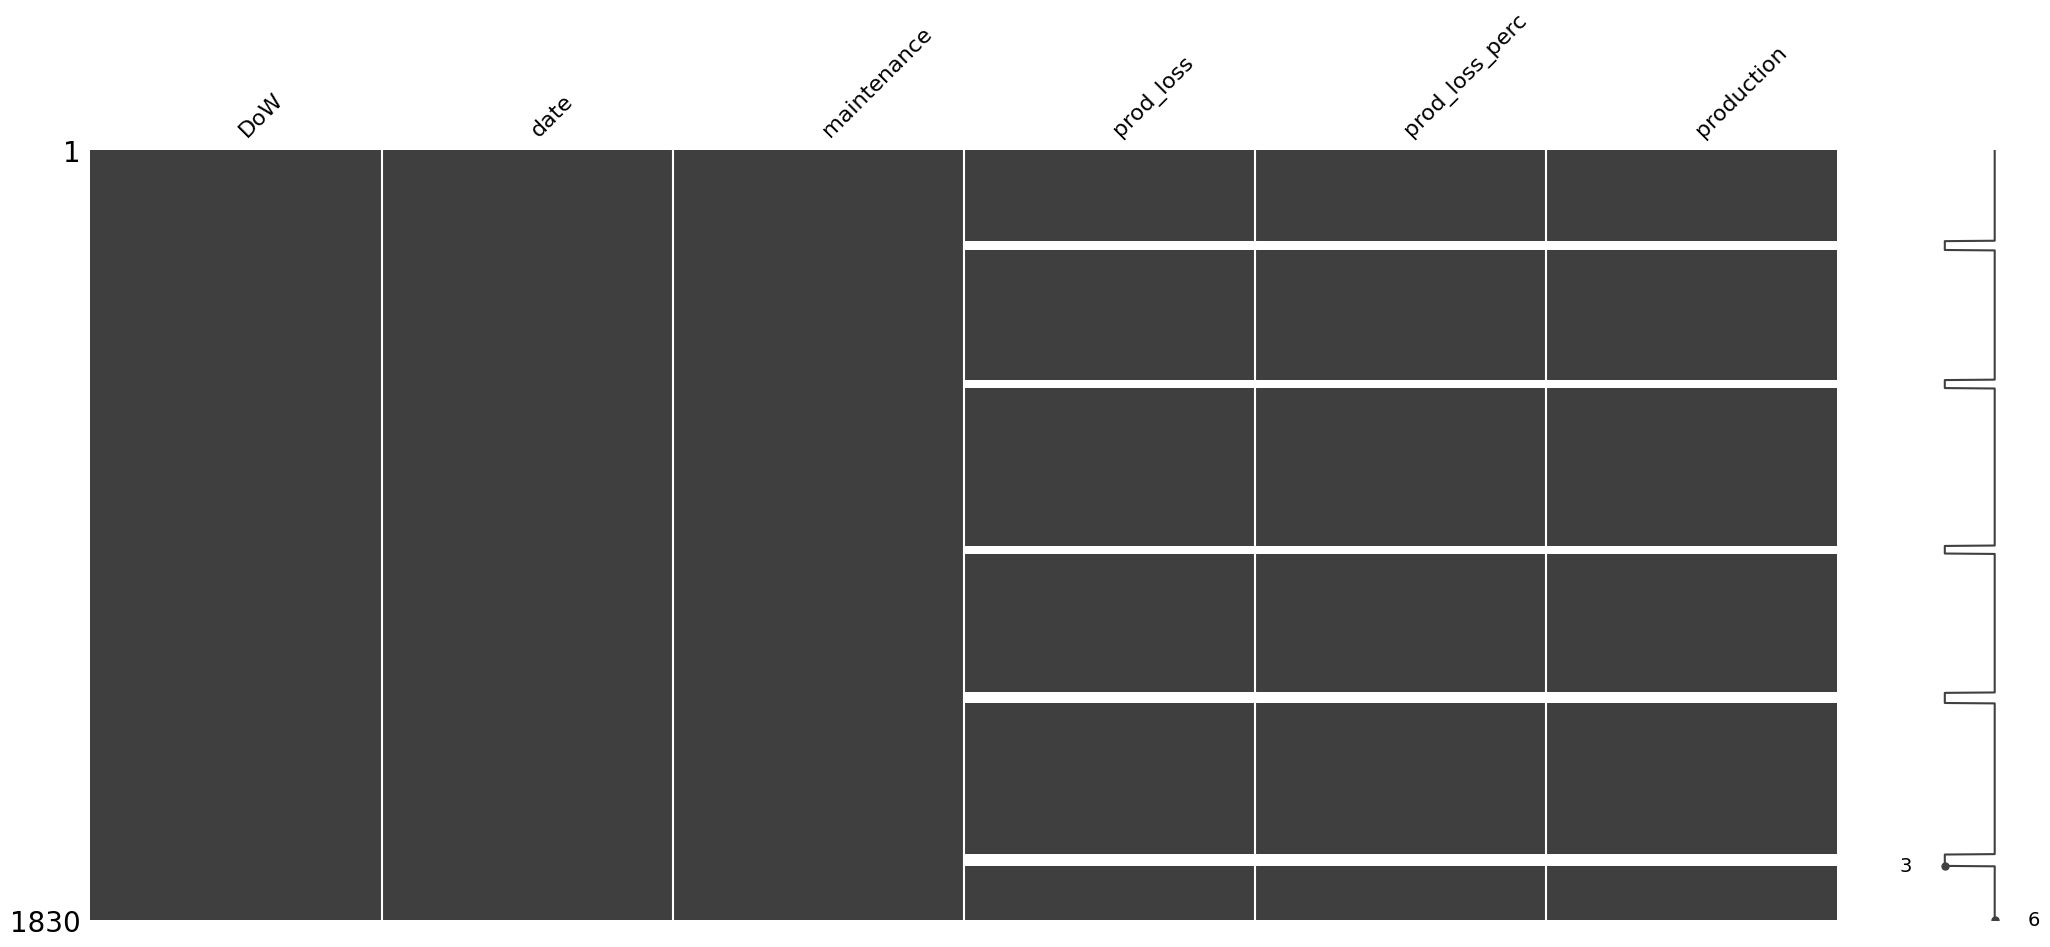

In [10]:
# check where missing values are
msno.matrix(df_daily);

In [11]:
# verify if all missing values coincide with maintenance
verify_df = df_daily.loc[df_daily['prod_loss'].isna(), 'maintenance'].eq('Yes').all()
verify_df

True

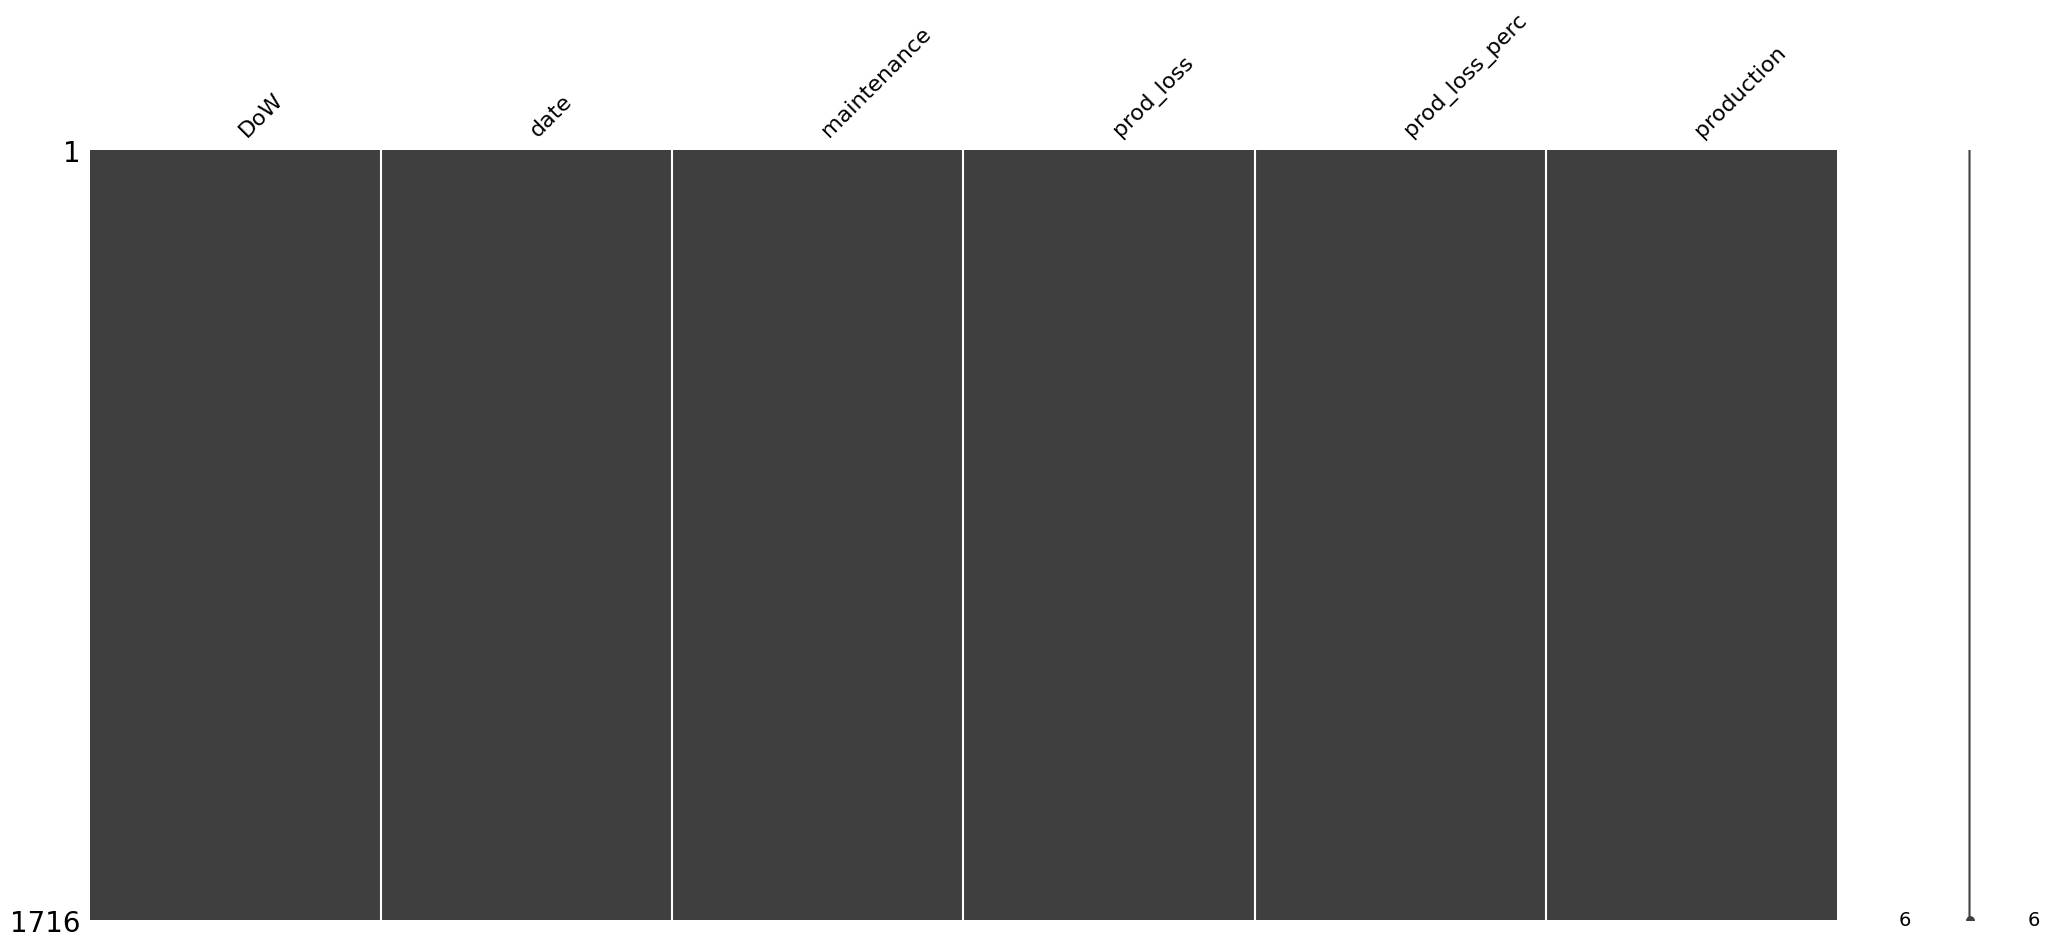

In [12]:
df_daily_noMT = df_daily.dropna()
msno.matrix(df_daily_noMT);

## Visualize

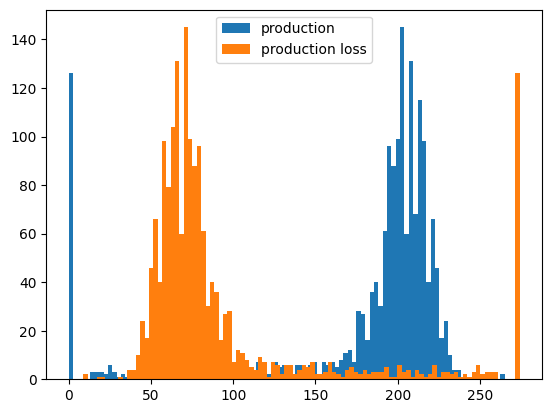

In [13]:
plt.hist(df_daily['production'], bins = 100, label = 'production');
plt.hist(df_daily['prod_loss'], bins = 100, label = 'production loss');
plt.legend();

## Parameters and subsets

In [14]:
# column to variable
prod_daily = df_daily['production']

# Maximal Sustainable Rate
msr = msr_data.iloc[0][f'{city} msr']
print('Maximal Sustainable Rate is', msr)

# 0 productie
perc_0 = np.mean(prod_daily < 10 ** (-1))
perc_MT = (prod_daily.shape[0] - df_daily_noMT.shape[0])/prod_daily.shape[0]
perc_no_prod = perc_0 + perc_MT
print('Kans op 0 productie is', f"{perc_0:.2%}")
print('Kans op 0 productie door maintenance is', f"{perc_MT:.2%}")
print('Totale kans op 0 productie is', f"{perc_no_prod:.2%}")

# niet 0 en outliers
prod_not_0 = prod_daily[prod_daily > 10 ** (-1)]
outliers_gone = remove_outlier(prod_not_0)
prod_not_out = outliers_gone[0]
tresh_low = outliers_gone[1]
tresh_high = outliers_gone[2]
perc_out_low = sum(i < tresh_low for i in prod_not_0)/prod_daily.shape[0]
perc_out_high = sum(i > tresh_high for i in prod_not_0)/prod_daily.shape[0]
print('Kans op outlier productie onder', tresh_low, 'is', f"{perc_out_low:.2%}")
print('Kans op outlier productie boven', tresh_high, 'is', f"{perc_out_high:.2%}")

# kans op normale productie
perc_prod = 1 - (perc_no_prod + perc_out_low + perc_out_high)
print('Kans op normale productie is', f"{perc_prod:.2%}")

Maximal Sustainable Rate is 274
Kans op 0 productie is 6.89%
Kans op 0 productie door maintenance is 6.23%
Totale kans op 0 productie is 13.11%
Kans op outlier productie onder 155.125 is 9.67%
Kans op outlier productie boven 246.125 is 0.22%
Kans op normale productie is 76.99%


In [15]:
avg = np.mean(prod_not_out)
std = np.std(prod_not_out)
print('gemiddelde: ', avg, '\nstd: ', std)

gemiddelde:  203.16891412349185 
std:  14.646576843353307


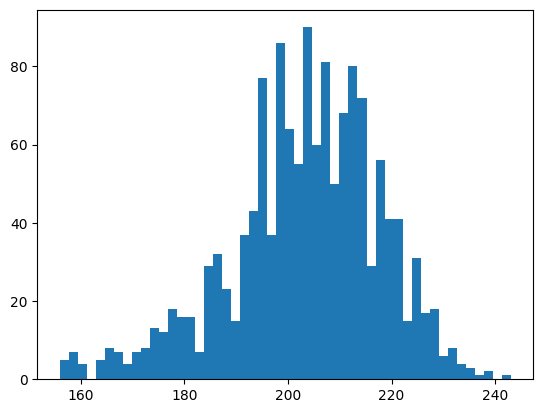

In [16]:
plt.hist(prod_not_out, bins = 50);

## Fit distributie

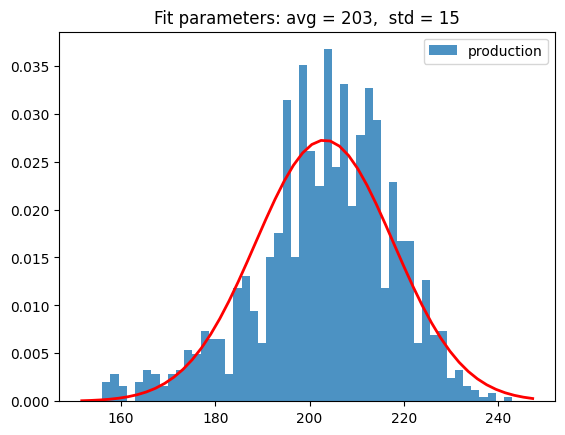

In [17]:
# fit normal distribution to the data
avg, std = norm.fit(prod_not_out)

# plot histogram
plt.hist(prod_not_out, bins = 50, density = True, alpha = 0.8, label = 'production')
plt.legend()

# plot pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, avg, std)
plt.plot(x, p, 'r', linewidth = 2)
title = "Fit parameters: avg = %.0f,  std = %.0f" % (avg, std)
plt.title(title)

plt.show()

## Simulatie

In [18]:
def sim(perc_no_prod, perc_out_low, perc_prod, perc_out_high, msr, avg, std, sample_size = 10 ** 3):
    """
    Functie genereert simulatie data obv parameters van betreffende stad voor 1 dag
    TODO: better option for 0 productie
    """
    distributions = [
        {'type': np.random.normal, 'kwargs': {'loc': 0, 'scale': 1/100}},
        {'type': np.random.uniform, 'kwargs': {'low': 0, 'high': tresh_low}},
        {'type': np.random.normal, 'kwargs': {'loc': avg, 'scale': std}},
        {'type': np.random.uniform, 'kwargs': {'low': tresh_high, 'high': msr}}
    ]
    coeff = np.array([perc_no_prod, perc_out_low, perc_prod, perc_out_high])
    coeff /= coeff.sum()
    num_dis = len(distributions)

    data = np.zeros((sample_size, num_dis))
    for idx, distr in enumerate(distributions):
        data[:, idx] = distr['type'](size = (sample_size,), **distr['kwargs'])
    random_idx = np.random.choice(np.arange(num_dis), size = (sample_size,), p = coeff)
    sim_data = data[np.arange(sample_size), random_idx]
    return sim_data

In [19]:
simulated = sim(perc_no_prod, perc_out_low, perc_prod, perc_out_high, msr, avg, std)

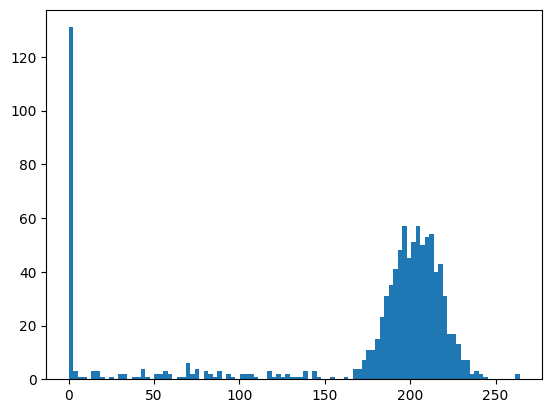

In [23]:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1)
plt.hist(simulated, bins = 100);

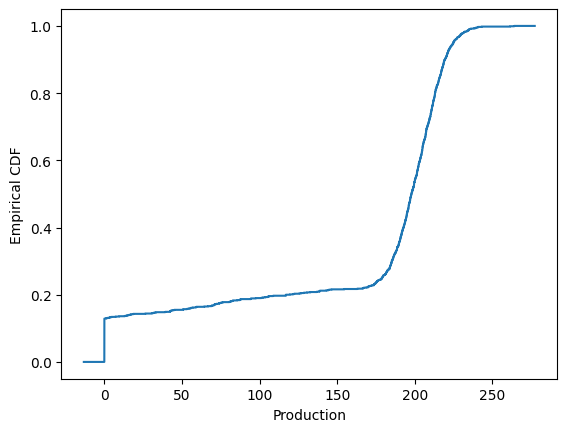

In [24]:
res = stats.ecdf(simulated)
ax = plt.subplot()
res.cdf.plot(ax)
ax.set_xlabel('Production')
ax.set_ylabel('Empirical CDF')
plt.show()